### Перенос стиля

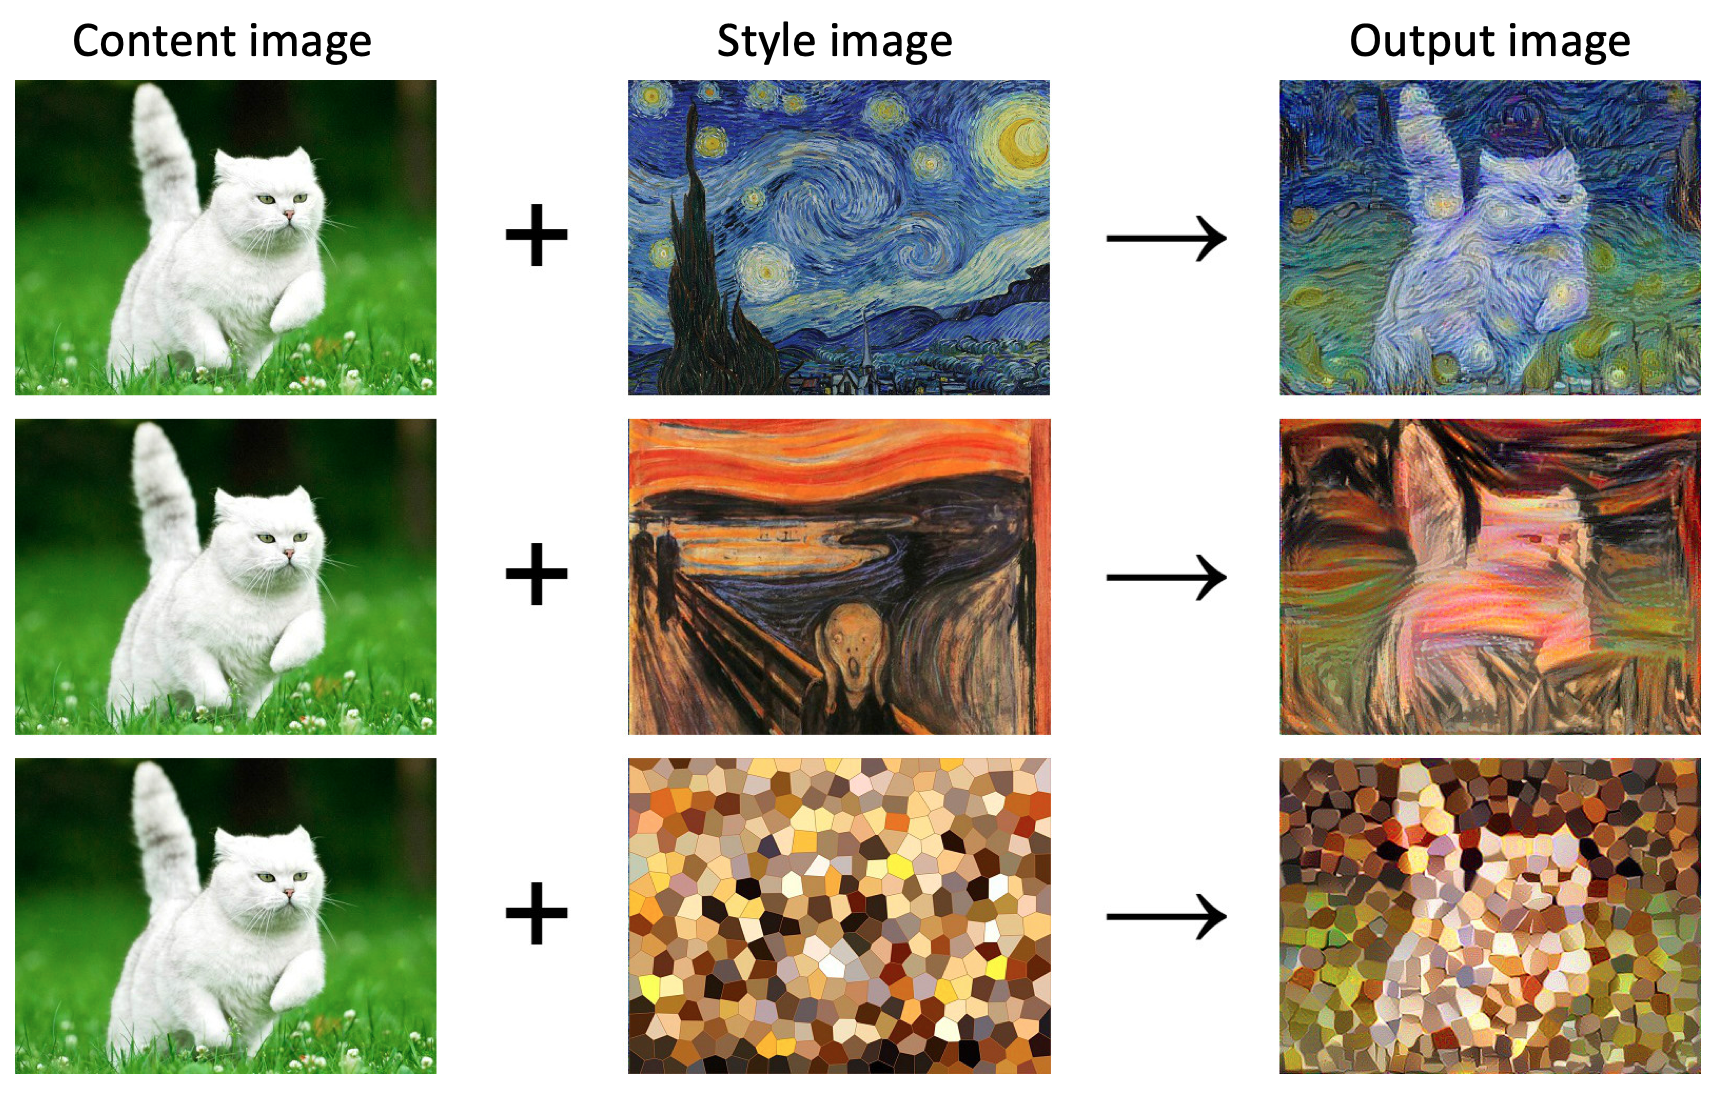

### Формальная постановка

У нас есть исходное изображение content. Мы бы хотели получить такое же изображение, но чтобы оно было в другом стиле (см. картинку). Чтобы реализовать это посмотрим какие части нейронной сети отвечают за контент и стиль.

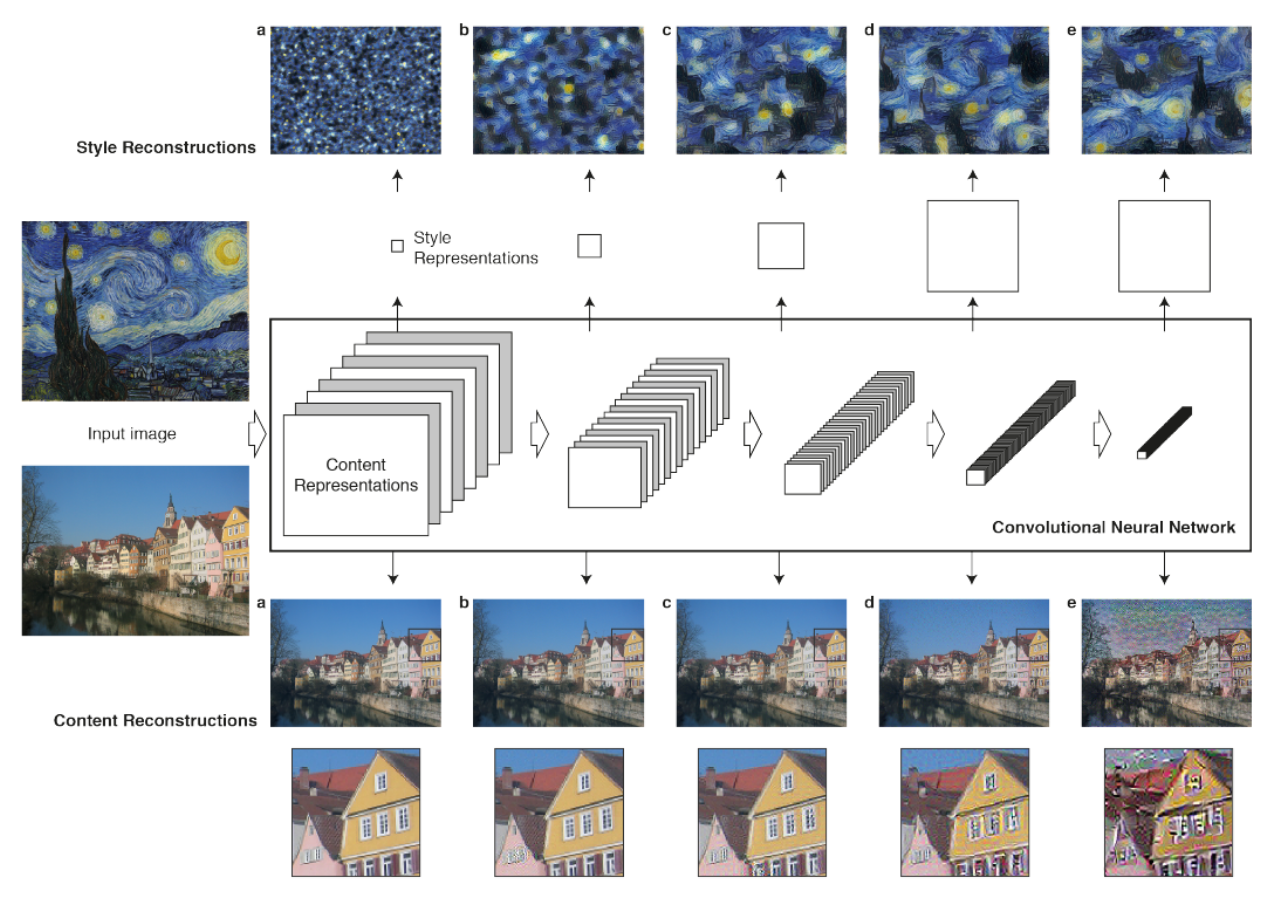

В обученной сети начальные слои отвечают за текстуры, простые цвета и т.д. Но с увеличением глубины нейронная сеть начинает распознавать более сложные паттерны, которые отвечают за содержание изображения

In [ ]:
import os 
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import cv2
import glob
import pandas as pd

from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from skimage import filters, restoration
from matplotlib import pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Загружаем предобуенную VGG модель, которую будем использовать для получения признакового описания

In [ ]:
vgg = torchvision.models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if image.size(0) != 1:
                features[layers[name]] = torch.mean(x, dim=0, keepdims=True)
            else:
                features[layers[name]] = x
    return features

def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

`Content loss `- функция, которая выдает взвешенное контентное расстояние для выхода отдельного слоя сетки. На вход она получает фичамапу входа $X$ со слоя $L$ - $F_{XL}$ и считает расстояние от $X$ до $C$ (в финальном лоссе ещё на вес умножим). Но понятное дело расстояние будем считать не до самой $C$, а до её представления на этом же слое - $F_{CL}$. 

То есть $D_S = ‖F_{XL}−F_{CL}‖^2$ и легко считается с помощью `pytorch`.

В сети для переноса стиля подсчет лосса - операция внутренняя, он считается по ходу движения $X$ через сеть, а значит на выход пойдет просто инпут

`Style loss` в целом похож на `Content` - он тоже будет жить между слоями и считать разницу между $N$-м представлением стиля и входа. Но здесь разницу мы будем считать между матрицами Грама $G_{XL}$. 

Как мы знаем, матрица Грама - это просто произведение $AA^T$. Для нашего кейса будем считать матрицу Грама для решейпнутых представлений $\hat{F}_{XL}$. Зачем она тут? Базово, мы хотим чтобы хорошо воспроизводились корреляции пар фичей, которые мы наблюдаем в картинке стиля.

Как получаем $\hat{F}_{XL}$: $F_{XL}$ мы решейпим к виду $KxN$, где $K$ - число фичамап (каналов) на слое $L$, а $N$ - длина любой векторизованной (`flatten`) фичамапы. То есть каждая строка $\hat{F}_{XLi}$ - это `flatten` $i$-ая фичамапа. 

В конце каждый элемент матрицы Грама надо нормализовать - поделить на число элементов в матрице, так мы не будем иметь проблем ни с какой размерностью фичамап.


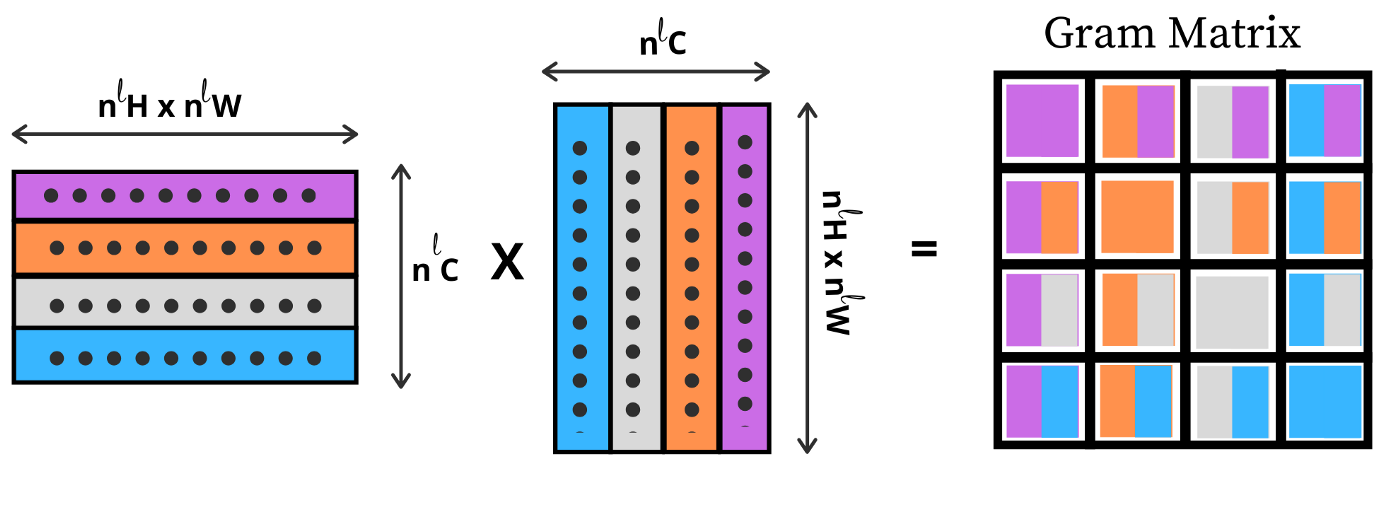

In [ ]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b, d, h, w = input.size()
        img = input.view(b, d, h*w) 
        G = torch.einsum("bij, bkj->bik", img, img) / h / w
        return G


class GramMSELoss(nn.Module):
    def forward(self, input, target):
        gram_loss = torch.norm(input - target, dim=(1, 2))
        return gram_loss

In [ ]:
img_size = 512
img_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), 
                                            (0.229, 0.224, 0.225))])

In [ ]:
style_layers = {'0': 'conv1_1',
                '5': 'conv2_1', 
                '10': 'conv3_1', 
                '19': 'conv4_1',
                '28': 'conv5_1',
                }
content_layers = {'21': 'conv4_2'}

In [ ]:
idx2layer = list(style_layers.values()) + list(content_layers.values())

In [ ]:
def prepare_for_train(content_path, style_path, img_size=512, vgg_size=224):
    content_img = Image.open(content_path).convert('RGB')
    style_img = Image.open(style_path).convert('RGB')

    if content_img.size[0] > img_size or content_img.size[1] > img_size:
        content_img = transforms.Resize(img_size)(content_img)

    style_img = transforms.Resize(img_size)(style_img)
    c_img = img_transform(content_img).unsqueeze(0).to(device)
    s_img = img_transform(style_img).unsqueeze(0).to(device)

    content_image = get_features(c_img, vgg, content_layers)
    style_image = get_features(s_img, vgg, style_layers)
    style_gram = {}
    for layer in style_image:
        style_gram[layer] = GramMatrix()(style_image[layer])
    
    return c_img, content_image, style_gram

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving roasting_phd.png to roasting_phd.png


In [ ]:
uploaded = files.upload()

Saving kand.jpg to kand.jpg


In [ ]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
style_weights = [1e4/n**2 for n in [64,128,256,512,512]]

content_weights = [1e-1]
tv_weights = [1e-2]
weights = style_weights + content_weights + tv_weights

content_path = '/content/roasting_phd.png'
style_path = '/content/kand.jpg'

c_img, content_image, style_gram = prepare_for_train(content_path, style_path)
#run style transfer
max_iter = 2000
optim_image = c_img.clone().requires_grad_()
optimizer = torch.optim.LBFGS([optim_image], lr=1e0, history_size=3, max_iter=50)


run = [0]
while run[0] <= max_iter:
    def closure():
        optim_image.data.clamp_(-2.1179, 2.2489)
        style_loss = 0.0
        content_loss = 0.0
        grad = 0.0

        optimizer.zero_grad()

        target_content = get_features(optim_image, vgg, content_layers)
        target_style = get_features(optim_image, vgg, style_layers)

        target_gram = {}
        for layer in target_style:
            target_gram[layer] = GramMatrix()(target_style[layer])

        for i in range(len(style_layers)):
            layer = idx2layer[i]
            style_loss = style_loss + weights[i] * loss_fns[i](target_gram[layer], style_gram[layer])

        for i in range(len(content_layers)):
            j = len(style_layers) + i 
            layer = idx2layer[j]
            content_loss = content_loss + weights[j] * loss_fns[j](target_content[layer], content_image[layer])
        loss = style_loss + content_loss
        loss.backward()
        run[0] += 1
        if (run[0] + 1) % 100 == 0:
            print(f"Iteration {run[0] + 1}: Loss {loss}")

        return loss
    
    optimizer.step(closure)

Iteration 100: Loss tensor([54.3972], device='cuda:0', grad_fn=<AddBackward0>)
Iteration 200: Loss tensor([43.2338], device='cuda:0', grad_fn=<AddBackward0>)
Iteration 300: Loss tensor([36.4695], device='cuda:0', grad_fn=<AddBackward0>)
Iteration 400: Loss tensor([32.7719], device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

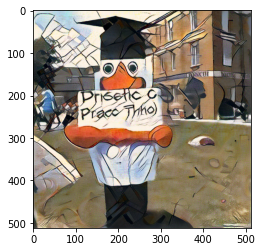

In [ ]:
tok = im_convert(optim_image)
plt.imshow(tok)
plt.show()